In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util
import plot as sds_plt

import numpy as np
#import cupy as cp
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pyshtools
import pickle

comment = "Simulation with dynamo midpath ensemble as training image with cov based on spectra"
nb_name = "nb_seqsim_core_sh30_spec_Cm"

# Core

In [2]:
shc_g = 30
shc_grid = 30
C_e_const = 2.0

core = SDSS(comment, N_SH = shc_g, sim_type = "core_ens", sat_height = 350)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([core.grid_phi, 90-core.grid_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = True)

core.generate_map(target_var_factor = 1)

In [3]:
core.condtab(normsize=1000, quantiles = 100, 
             rangn_lim = 3.5, rangn_N = 101, rangv_lim = 2.0, rangv_N = 101) #model_hist = "ensemble"

In [4]:
core.semivar(model_lags = 20, model = "exponential", max_dist = 20000, lag_length = 100,
             zero_nugget = True, hit_target_var = False)

____semi-variogram setup___

Number of data used: 3575881
Max data distance: 10919.075 km
Lag length chosen: 100.0 km
Number of lags: 109
Number of modelling lags: 20

Semi-variogram model determined, starting LUT computation



In [5]:
g_core_ens = np.genfromtxt("lithosphere_prior/grids/shcoeff_Dynamo/gnm_midpath.dat").T*10**9
g_core_ens = g_core_ens[:mt_util.shc_vec_len(shc_g),:]

core.ensemble_B(g_core_ens, nmax = shc_g, r_at = core.r_cmb, grid_type = "glq")
m_core_ens = core.B_ensemble[:,0,:].copy()[:,200:]

var_core_ens = np.var(m_core_ens,axis=0)

idx_close_to_var = np.argwhere(np.logical_and(var_core_ens>0.9970*np.mean(var_core_ens), var_core_ens<1.0030*np.mean(var_core_ens)))

In [6]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

a = core.a
c = core.r_cmb
n_max = shc_g

g_cut = g_core_ens[:shc_g*(2+shc_g),200:] # Truncate g
R = mt_util.lowe_shspec(n_max,c,a,g_cut)
print(R.shape)

theta_s, theta_d, phi_s, phi_d = map(np.radians, 
                                     [core.grid_theta.reshape(1,-1), core.grid_theta.reshape(-1,1), 
                                      core.grid_phi.reshape(1,-1), core.grid_phi.reshape(-1,1)])

c_angdist = np.cos(theta_d)*np.cos(theta_s)+np.multiply(np.sin(theta_d)@np.sin(theta_s),np.cos(phi_d-phi_s))

c_angdist[c_angdist>1.0] = 1.0
c_angdist[c_angdist<-1.0] = -1.0

andist_deg = np.arccos(c_angdist)*180/np.pi

#c_angdist[andist_deg>90] = np.cos(90)*np.pi/180
#c_angdist[c_angdist>0.8] = 0.8
print(c_angdist.shape)

andist_deg = np.arccos(c_angdist)*180/np.pi

(30, 487)
(1891, 1891)


<IPython.core.display.Javascript object>


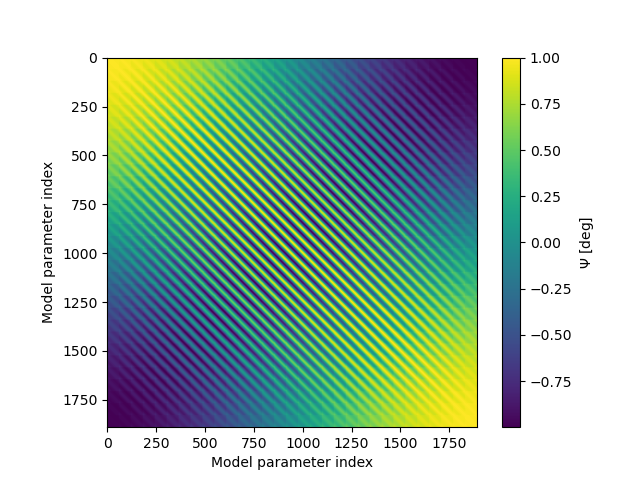

In [7]:
plt.figure()
#plt.imshow(andist_deg)
plt.imshow(c_angdist)
plt.colorbar(label="$\Psi$ [deg]")
plt.xlabel("Model parameter index")
plt.ylabel("Model parameter index")
plt.show()

In [8]:
R_use = R[:,[int(core.ens_idx)]]
#R_use = R
#R_use = np.mean(R,axis=1).reshape(-1,1)

In [9]:
C_const = (np.arange(1,n_max+1)+1)/(2*np.arange(1,n_max+1)+1)

C_Br = []

#i = 0
#i_t = len(np.ravel(c_angdist))
for cmu in np.ravel(c_angdist):
    C_Br.append(np.sum(C_const.reshape(-1,1)*R_use*pyshtools.legendre.PlSchmidt(n_max,cmu)[1:].reshape(-1,1),axis=0))
    #mt_util.printProgressBar(i,i_t,sleep_time = 0.0001)
    #i += 1
    
C_Br = np.array(C_Br).reshape((c_angdist.shape[0],c_angdist.shape[1],-1))
if C_Br.shape[2] == 1:
    C_Br = C_Br[:,:,0]

In [10]:
C_Br.shape

(1891, 1891)

In [11]:
#C_Br_zero = C_Br.copy()
#C_Br_zero[C_Br_zero<0.0] = 0.0

In [12]:
import scipy.linalg as spl

# Function for testing positive definiteness
def is_pos_def(A):
    if np.allclose(A, A.conj().T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [13]:
core_eigval = spl.eigh(C_Br, eigvals_only=True)
print(is_pos_def(C_Br))
print(np.all(core_eigval>=0))

False
False


In [14]:
#core_eigval = spl.eigh(C_Br_zero, eigvals_only=True)
#print(is_pos_def(C_Br_zero))
#print(np.all(core_eigval>=0))

In [15]:
#for i in np.arange(0,C_Br.shape[2]):
#    #core_eigval = spl.eigh(C_Br[:,:,i], eigvals_only=True)
#    ipd = is_pos_def(C_Br[:,:,i])
#    #pos_eig = np.all(core_eigval>=0)
#    
#    #if np.logical_or(ipd == True, pos_eig == True):
#    if ipd == True:
#        print(ipd)
#        #print(pos_eig)
#        print(i)

<IPython.core.display.Javascript object>


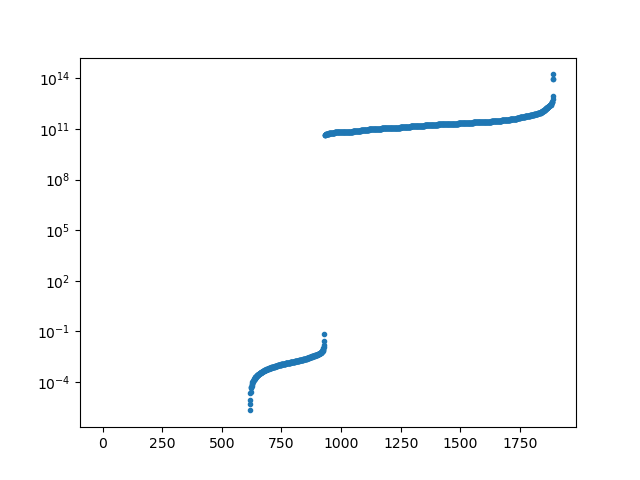

(617,)

In [16]:
plt.figure()
plt.semilogy(core_eigval,'.')
plt.show()

core_eigval[core_eigval<=0].shape

In [17]:
core.target_var = 1*np.max(C_Br)

In [18]:
sv_spec = core.target_var - C_Br
#sv_spec = np.max(C_Br) - C_Br
skip = 1

sph_d_skip = np.ravel(core.sph_d.reshape((core.N_grid,core.N_grid))[0::skip,0::skip])

i_sph_d_skip = np.argsort(sph_d_skip)

<IPython.core.display.Javascript object>


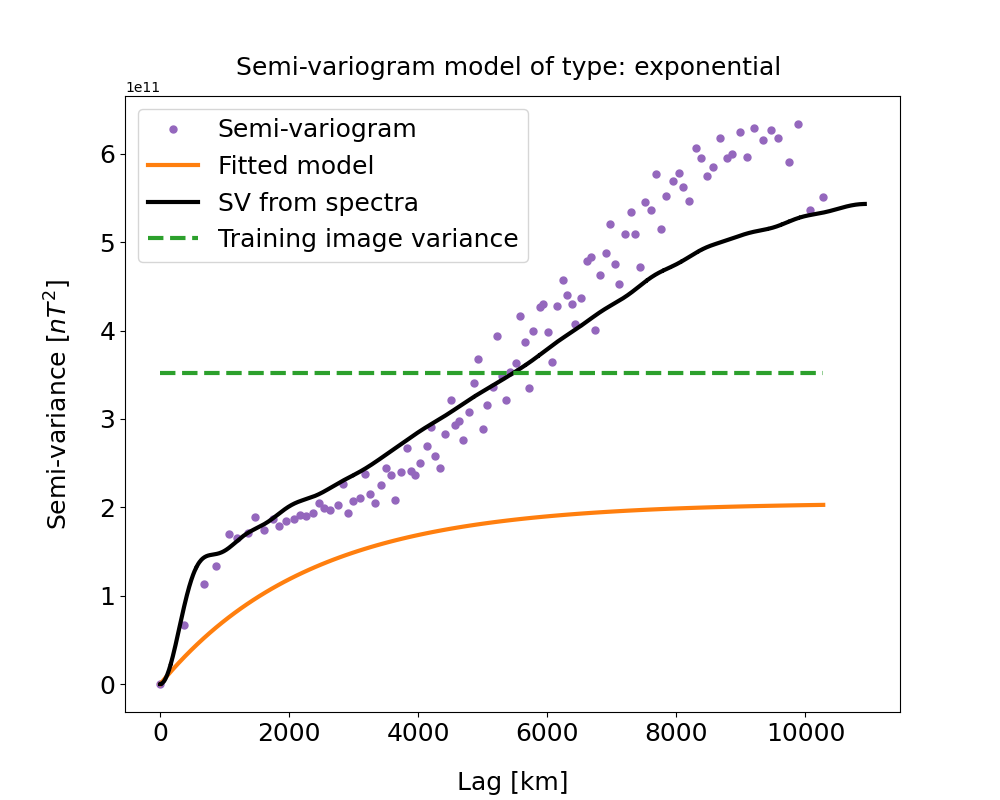

In [19]:
#%% PLOT SEMI-VARIOGRAM
plt.figure(figsize=(10,8)) 
plt.plot(core.lags,core.pics,'o', markersize=5,color = 'C4',label='Semi-variogram')

plt.plot(core.lags_sv_curve,core.sv_curve,color='C1', linewidth = 3,label='Fitted model')

plt.plot(sph_d_skip[i_sph_d_skip], np.ravel(sv_spec[0::skip,0::skip])[i_sph_d_skip], 
                 linewidth = 3, color="k", label='SV from spectra')

plt.plot(core.lags_sv_curve,np.ones(core.lags_sv_curve.shape)*core.target_var,linewidth = 3,
         color="C2", linestyle="dashed", label="Training image variance")
plt.ylabel('Semi-variance $[%s^2]$' % "nT",fontsize=18,labelpad=18)
plt.xlabel('Lag [km]',fontsize=18,labelpad=18)
plt.title("Semi-variogram model of type: %s " % core.model_names[core.model],fontsize=18,y=1.02)
plt.legend(loc='best',fontsize=18)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.show()

# Synthetic sat

In [107]:
s_sat = SDSS(comment, N_SH = shc_g, sim_type = "core", sat_height = 350, N_SH_secondary = None)

s_sat.load_swarm("A")

grid_in = np.array([s_sat.grid_phi, 90-s_sat.grid_theta]).T
s_sat.make_grid(s_sat.grid_radial, grid_in, calc_sph_d = False)

In [108]:
s_sat.generate_map(grid_type = "swarm")

In [109]:
s_sat.data += np.random.normal(scale = C_e_const, size = s_sat.data.shape)

# Source truth

In [110]:
s_source = SDSS(comment, N_SH = shc_g, sim_type = "core", sat_height = 350, N_SH_secondary = None)

s_source.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([s_source.grid_phi, 90-s_source.grid_theta]).T
s_source.make_grid(s_source.r_cmb, grid_in, calc_sph_d = False)

s_source.generate_map()

# System equations

In [124]:
core.integrating_kernel(s_sat, C_e_const = C_e_const, C_mm_supply = C_Br)

In [125]:
#print(core)

# SDSSIM

In [126]:
N_sim = 4

core.run_sim(N_sim, core.grid_N, core.C_mm_all, core.C_dd, core.C_dm_all, core.G,
        s_sat.data, core.data, scale_m_i = False, unit_d = False, collect_all = True,
        sense_running_error = True, save_string = nb_name, sim_stochastic = False, solve_cho = False)

 |OO--------| 23.8%   realization nr. 0. Counter: 450/1891, Running error magnitude: 5.5
Negative kriging variance: -0.041015625

 |OO--------| 24.6%   realization nr. 0. Counter: 465/1891, Running error magnitude: 5.5
Negative kriging variance: -0.0030517578125

 |OO--------| 26.7%   realization nr. 0. Counter: 505/1891, Running error magnitude: 5.6
Negative kriging variance: -11562303.046508789

 |OOO-------| 30.1%   realization nr. 0. Counter: 569/1891, Running error magnitude: 5.7
Negative kriging variance: -0.0076904296875

 |OOO-------| 30.6%   realization nr. 0. Counter: 579/1891, Running error magnitude: 5.7
Negative kriging variance: -643179335.0465088

 |OOO-------| 30.8%   realization nr. 0. Counter: 583/1891, Running error magnitude: 5.7
Negative kriging variance: -0.0147705078125

 |OOO-------| 32.4%   realization nr. 0. Counter: 612/1891, Running error magnitude: 5.7
Negative kriging variance: -0.0006103515625

 |OOO-------| 32.9%   realization nr. 0. Counter: 623/1891, R

 |OOOOO-----| 53.4%   realization nr. 0. Counter: 1009/1891, Running error magnitude: 6.0
Negative kriging variance: -0.0028076171875

 |OOOOO-----| 53.5%   realization nr. 0. Counter: 1011/1891, Running error magnitude: 6.0
Negative kriging variance: -0.0015869140625

 |OOOOO-----| 53.7%   realization nr. 0. Counter: 1016/1891, Running error magnitude: 6.0
Negative kriging variance: -11.26776123046875

 |OOOOO-----| 53.8%   realization nr. 0. Counter: 1017/1891, Running error magnitude: 6.0
Negative kriging variance: -0.0174560546875

 |OOOOO-----| 53.8%   realization nr. 0. Counter: 1018/1891, Running error magnitude: 6.0
Negative kriging variance: -2.54827880859375

 |OOOOO-----| 53.9%   realization nr. 0. Counter: 1019/1891, Running error magnitude: 6.0
Negative kriging variance: -264.0465087890625

 |OOOOO-----| 53.9%   realization nr. 0. Counter: 1020/1891, Running error magnitude: 6.0
Negative kriging variance: -752451.8682861328

 |OOOOO-----| 54.2%   realization nr. 0. Counter

 |OOOOOO----| 61.9%   realization nr. 0. Counter: 1170/1891, Running error magnitude: 6.0
Negative kriging variance: -0.88934326171875

 |OOOOOO----| 62.0%   realization nr. 0. Counter: 1173/1891, Running error magnitude: 6.0
Negative kriging variance: -0.7574462890625

 |OOOOOO----| 62.1%   realization nr. 0. Counter: 1175/1891, Running error magnitude: 6.0
Negative kriging variance: -0.000732421875

 |OOOOOO----| 62.2%   realization nr. 0. Counter: 1177/1891, Running error magnitude: 6.0
Negative kriging variance: -0.0379638671875

 |OOOOOO----| 62.3%   realization nr. 0. Counter: 1178/1891, Running error magnitude: 6.0
Negative kriging variance: -158.4234619140625

 |OOOOOO----| 62.3%   realization nr. 0. Counter: 1179/1891, Running error magnitude: 6.0
Negative kriging variance: -0.0050048828125

 |OOOOOO----| 62.4%   realization nr. 0. Counter: 1180/1891, Running error magnitude: 6.0
Negative kriging variance: -4.5001220703125

 |OOOOOO----| 62.5%   realization nr. 0. Counter: 118

 |OOOOOO----| 66.6%   realization nr. 0. Counter: 1260/1891, Running error magnitude: 6.0
Negative kriging variance: -0.04559326171875

 |OOOOOO----| 66.7%   realization nr. 0. Counter: 1261/1891, Running error magnitude: 6.0
Negative kriging variance: -59.5465087890625

 |OOOOOO----| 66.7%   realization nr. 0. Counter: 1262/1891, Running error magnitude: 6.0
Negative kriging variance: -0.02142333984375

 |OOOOOO----| 66.8%   realization nr. 0. Counter: 1263/1891, Running error magnitude: 6.0
Negative kriging variance: -0.0113525390625

 |OOOOOO----| 66.9%   realization nr. 0. Counter: 1265/1891, Running error magnitude: 6.0
Negative kriging variance: -0.0726318359375

 |OOOOOO----| 67.1%   realization nr. 0. Counter: 1269/1891, Running error magnitude: 6.0
Negative kriging variance: -0.0250244140625

 |OOOOOO----| 67.2%   realization nr. 0. Counter: 1270/1891, Running error magnitude: 6.0
Negative kriging variance: -47.03466796875

 |OOOOOO----| 67.2%   realization nr. 0. Counter: 127

 |OOOOOOO---| 71.9%   realization nr. 0. Counter: 1360/1891, Running error magnitude: 6.1
Negative kriging variance: -1.79736328125

 |OOOOOOO---| 72.0%   realization nr. 0. Counter: 1361/1891, Running error magnitude: 6.1
Negative kriging variance: -0.0028076171875

 |OOOOOOO---| 72.1%   realization nr. 0. Counter: 1363/1891, Running error magnitude: 6.1
Negative kriging variance: -0.0198974609375

 |OOOOOOO---| 72.1%   realization nr. 0. Counter: 1364/1891, Running error magnitude: 6.1
Negative kriging variance: -0.95526123046875

 |OOOOOOO---| 72.2%   realization nr. 0. Counter: 1365/1891, Running error magnitude: 6.1
Negative kriging variance: -0.007080078125

 |OOOOOOO---| 72.2%   realization nr. 0. Counter: 1366/1891, Running error magnitude: 6.1
Negative kriging variance: -0.00164794921875

 |OOOOOOO---| 72.3%   realization nr. 0. Counter: 1367/1891, Running error magnitude: 6.1
Negative kriging variance: -0.00738525390625

 |OOOOOOO---| 72.3%   realization nr. 0. Counter: 1368/

 |OOOOOOO---| 76.4%   realization nr. 0. Counter: 1444/1891, Running error magnitude: 6.1
Negative kriging variance: -0.00604248046875

 |OOOOOOO---| 76.4%   realization nr. 0. Counter: 1445/1891, Running error magnitude: 6.1
Negative kriging variance: -0.01708984375

 |OOOOOOO---| 76.5%   realization nr. 0. Counter: 1446/1891, Running error magnitude: 6.1
Negative kriging variance: -0.02734375

 |OOOOOOO---| 76.5%   realization nr. 0. Counter: 1447/1891, Running error magnitude: 6.1
Negative kriging variance: -0.21002197265625

 |OOOOOOO---| 76.6%   realization nr. 0. Counter: 1448/1891, Running error magnitude: 6.1
Negative kriging variance: -0.01318359375

 |OOOOOOO---| 76.6%   realization nr. 0. Counter: 1449/1891, Running error magnitude: 6.1
Negative kriging variance: -0.00897216796875

 |OOOOOOO---| 76.8%   realization nr. 0. Counter: 1452/1891, Running error magnitude: 6.1
Negative kriging variance: -0.01544189453125

 |OOOOOOO---| 76.8%   realization nr. 0. Counter: 1453/1891,

 |OOOOOOOO--| 80.8%   realization nr. 0. Counter: 1527/1891, Running error magnitude: 6.1
Negative kriging variance: -0.0367431640625

 |OOOOOOOO--| 80.8%   realization nr. 0. Counter: 1528/1891, Running error magnitude: 6.1
Negative kriging variance: -0.00579833984375

 |OOOOOOOO--| 80.9%   realization nr. 0. Counter: 1529/1891, Running error magnitude: 6.1
Negative kriging variance: -0.00042724609375

 |OOOOOOOO--| 81.2%   realization nr. 0. Counter: 1535/1891, Running error magnitude: 6.1
Negative kriging variance: -0.15185546875

 |OOOOOOOO--| 81.2%   realization nr. 0. Counter: 1536/1891, Running error magnitude: 6.1
Negative kriging variance: -0.0704345703125

 |OOOOOOOO--| 81.3%   realization nr. 0. Counter: 1538/1891, Running error magnitude: 6.1
Negative kriging variance: -0.00384521484375

 |OOOOOOOO--| 81.4%   realization nr. 0. Counter: 1539/1891, Running error magnitude: 6.1
Negative kriging variance: -0.00341796875

 |OOOOOOOO--| 81.4%   realization nr. 0. Counter: 1540/1

 |OOOOOOOO--| 86.0%   realization nr. 0. Counter: 1627/1891, Running error magnitude: 6.1
Negative kriging variance: -0.00311279296875

 |OOOOOOOO--| 86.1%   realization nr. 0. Counter: 1628/1891, Running error magnitude: 6.1
Negative kriging variance: -0.00823974609375

 |OOOOOOOO--| 86.1%   realization nr. 0. Counter: 1629/1891, Running error magnitude: 6.1
Negative kriging variance: -0.00762939453125

 |OOOOOOOO--| 86.2%   realization nr. 0. Counter: 1630/1891, Running error magnitude: 6.1
Negative kriging variance: -0.00396728515625

 |OOOOOOOO--| 86.3%   realization nr. 0. Counter: 1631/1891, Running error magnitude: 6.1
Negative kriging variance: -0.00311279296875

 |OOOOOOOO--| 86.3%   realization nr. 0. Counter: 1632/1891, Running error magnitude: 6.1
Negative kriging variance: -0.002197265625

 |OOOOOOOO--| 86.4%   realization nr. 0. Counter: 1633/1891, Running error magnitude: 6.1
Negative kriging variance: -0.0062255859375

 |OOOOOOOO--| 86.4%   realization nr. 0. Counter: 1

 |OOOOOOOOO-| 91.0%   realization nr. 0. Counter: 1720/1891, Running error magnitude: 6.1
Negative kriging variance: -0.0042724609375

 |OOOOOOOOO-| 91.0%   realization nr. 0. Counter: 1721/1891, Running error magnitude: 6.1
Negative kriging variance: -0.01080322265625

 |OOOOOOOOO-| 91.1%   realization nr. 0. Counter: 1722/1891, Running error magnitude: 6.1
Negative kriging variance: -0.00738525390625

 |OOOOOOOOO-| 91.2%   realization nr. 0. Counter: 1724/1891, Running error magnitude: 6.1
Negative kriging variance: -0.02880859375

 |OOOOOOOOO-| 91.2%   realization nr. 0. Counter: 1725/1891, Running error magnitude: 6.1
Negative kriging variance: -0.00439453125

 |OOOOOOOOO-| 91.3%   realization nr. 0. Counter: 1726/1891, Running error magnitude: 6.1
Negative kriging variance: -0.0023193359375

 |OOOOOOOOO-| 91.3%   realization nr. 0. Counter: 1727/1891, Running error magnitude: 6.1
Negative kriging variance: -0.0140380859375

 |OOOOOOOOO-| 91.4%   realization nr. 0. Counter: 1729/18

 |OOOOOOOOO-| 96.6%   realization nr. 0. Counter: 1827/1891, Running error magnitude: 6.1
Negative kriging variance: -0.00396728515625

 |OOOOOOOOO-| 96.7%   realization nr. 0. Counter: 1828/1891, Running error magnitude: 6.1
Negative kriging variance: -0.00762939453125

 |OOOOOOOOO-| 96.7%   realization nr. 0. Counter: 1829/1891, Running error magnitude: 6.1
Negative kriging variance: -0.0184326171875

 |OOOOOOOOO-| 96.8%   realization nr. 0. Counter: 1830/1891, Running error magnitude: 6.1
Negative kriging variance: -0.0069580078125

 |OOOOOOOOO-| 96.8%   realization nr. 0. Counter: 1831/1891, Running error magnitude: 6.1
Negative kriging variance: -0.01043701171875

 |OOOOOOOOO-| 96.9%   realization nr. 0. Counter: 1832/1891, Running error magnitude: 6.1
Negative kriging variance: -0.0064697265625

 |OOOOOOOOO-| 96.9%   realization nr. 0. Counter: 1833/1891, Running error magnitude: 6.1
Negative kriging variance: -0.0169677734375

 |OOOOOOOOO-| 97.0%   realization nr. 0. Counter: 18

KeyboardInterrupt: 

In [48]:
core.realization_to_sh_coeff(core.r_cmb, set_nmax = shc_grid)

In [49]:
#core.covmod_lsq_equiv(s_sat.data, C_Br, core.G, core.r_cmb)

<IPython.core.display.Javascript object>


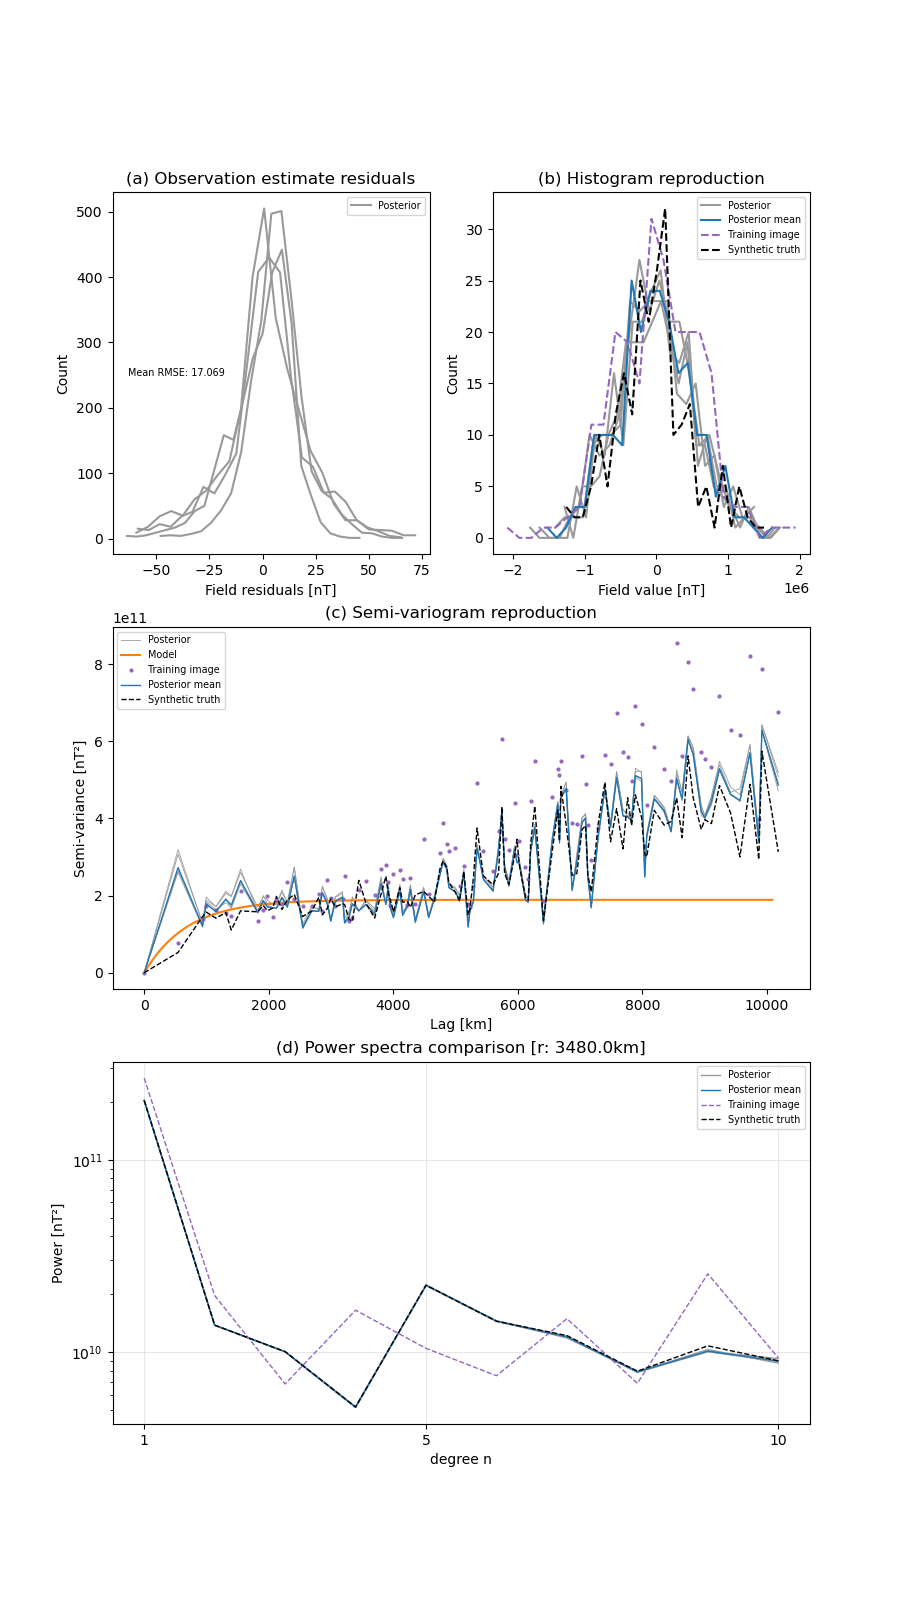

In [50]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
#core.m_equiv_lsq
core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
mt_util.plot_sdssim_reproduce(core, core.m_DSS_res, m_equiv_lsq = None, truth_obj = s_source,
                              lags_use = 1000, spec_r_at = core.r_cmb, spec_show_differences = False,
                              model_dict = {}, figsize=(9,16),
                              hist_bins = 25, res_bins = 25,
                              savefig = False, save_string = "core_sh30_newTI", save_dpi = 300)

In [47]:
skip = 1

m_skip = core.m_DSS[:,:][0::skip]

lat_skip = core.lat[0::skip]

lon_skip = core.lon[0::skip]

In [48]:
N_bins = 20
m_centers = []
m_y = []

for i in np.arange(0,m_skip.shape[0]):
    y,binEdges=np.histogram(m_skip[i,:],bins=N_bins)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    
    m_centers.append(bincenters)
    m_y.append(y)
    
m_centers = np.array(m_centers)
m_y = np.array(m_y)

In [49]:
deg_range = 1

lat_skip_lin = np.linspace(lat_skip-deg_range,lat_skip+deg_range,N_bins)
lon_skip_lin = np.linspace(lon_skip-2*deg_range,lon_skip+2*deg_range,N_bins)

In [50]:
m_y_scaled = []

for i in np.arange(0,m_skip.shape[0]):
    scale = np.min(lat_skip_lin[:,i]) + (m_y[i,:]-np.min(m_y[i,:]))*(np.max(lat_skip_lin[:,i])-np.min(lat_skip_lin[:,i]))/(np.max(m_y[i,:])-np.min(m_y[i,:]))

    m_y_scaled.append(scale)
    
m_y_scaled = np.array(m_y_scaled)

In [51]:
local_lat = m_y_scaled.reshape(-1,)

local_lon = lon_skip_lin.T.reshape(-1,)

local_data = m_centers.reshape(-1,)

<IPython.core.display.Javascript object>


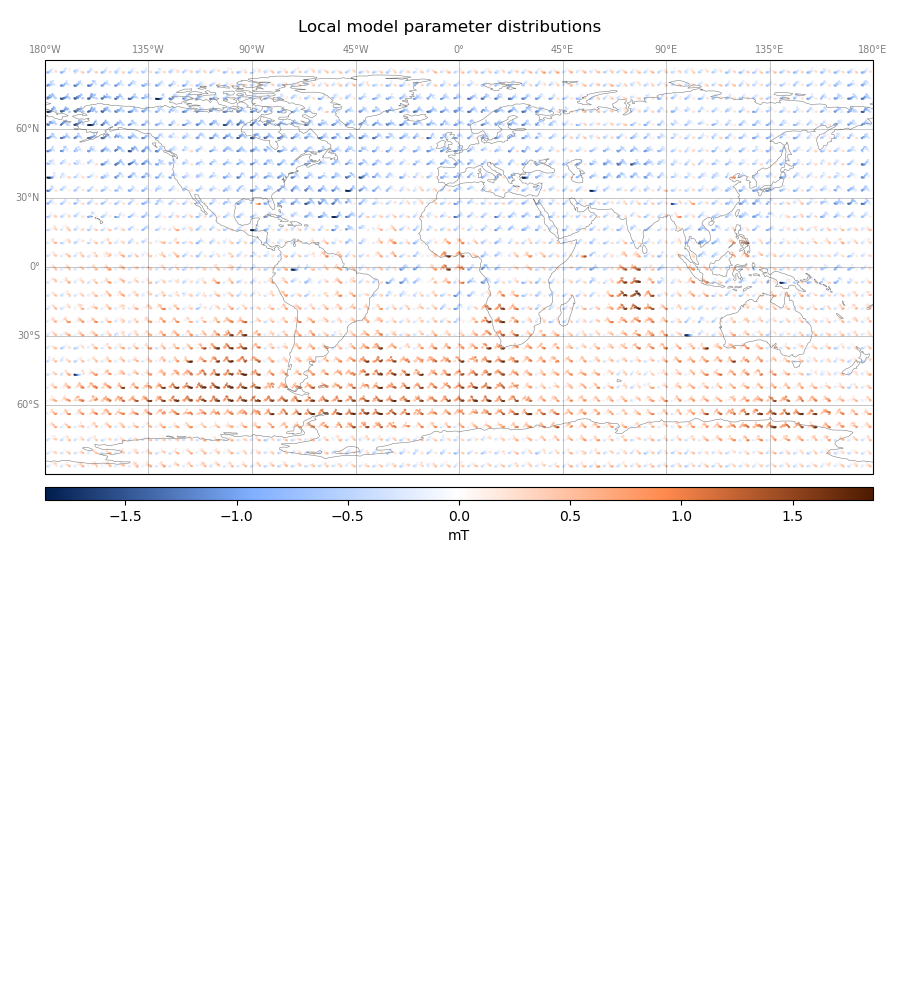

In [52]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)



mt_util.plot_global(lat = local_lat, lon = local_lon, data = local_data, 
                cbar_h = 0.03, cbar_mm_factor = 2/3, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(9,10), coast_width = 0.4,
                bottom=0.5, top=0.95, hspace=0.01, left = 0.05,
                title='Local model parameter distributions', point_size=0.1, projection_transformation = "PlateCarree",
                savefig = False, save_dpi = 100, save_string ="core_sh30_newTI_loc_mod_dist",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

In [51]:
core.grid_glq(nmax = 256, r_at = core.r_cmb)
#core.grid_glq(nmax = 120, r_at = core.r_cmb)

set_nmax = shc_grid

core.ensemble_B(core.g_spec, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0,:].copy()

#core.g_spec_mean = np.mean(core.g_spec,axis=1)
core.ensemble_B(core.g_spec_mean, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_mean_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
core.ensemble_B(s_sat.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
prior_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_lsq_equiv, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#lsq_eqa = core.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


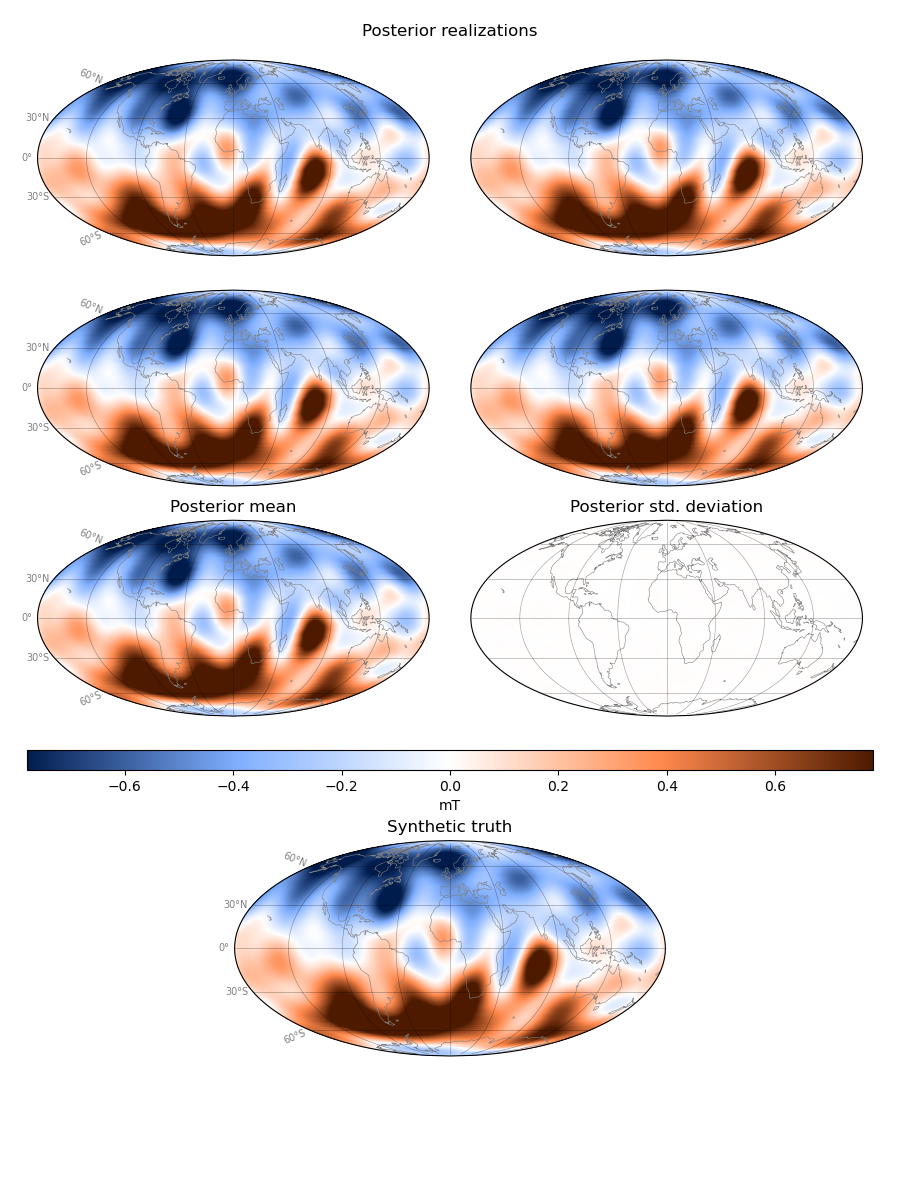

In [52]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.grid_phi, 90-core.grid_theta, zs_eqa, 
                        field_compare = prior_eqa, field_lsq = None, field_mean = zs_mean_eqa,
                        tile_size_row = 3, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 10, cbar_mm_factor = 2/3,
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = True,
                        cbar_h = 0.1, cbar_text = "mT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.25, 
                        savefig = False, save_string = "core_sh30_newTI", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)


<IPython.core.display.Javascript object>


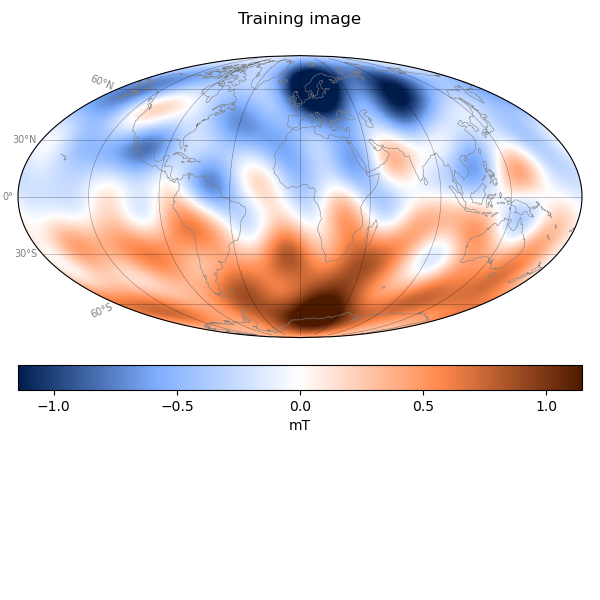

In [45]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
training_image = core.B_ensemble[:,0].copy()

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=training_image, 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Training image', point_size=1,
                savefig = False, save_dpi = 100, save_string ="core_sh30_synth_TI",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

In [23]:
# SAVE RESULT
#print("\nSaving job")
#file_clip = open("core_{}.obj".format(nb_name), "wb")
#pickle.dump(core, file_clip, protocol=4)
#file_clip.close()

#file_clip = open("sat_{}.obj".format(nb_name), "wb")
#pickle.dump(s_sat, file_clip, protocol=4)
#file_clip.close()
#print("\nJob saved and finished")